___


# Example for no-limit Texas Holdem in R

Let's train our Texas Holdem in R!

## > Install packages
We need to install packages Install package `reticulate` first by `install.packages("reticulate")`. The reticulate can be used for virtual envirnment creation and python packages connection. 

In [1]:
install.packages("reticulate")
library(reticulate)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)



Then we need to install pakcage `imager` for  plotting.

In [2]:
install.packages("imager")
library(imager)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)

Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




## > Virtual Environment
Now use `virtualenv_create('r-rlcard') ` to create a virtual environment called "r-rlcard"


In [3]:
virtualenv_create('r-rlcard')

virtualenv: r-rlcard


 Let's check if the virtual environment existes and use it for our training.

In [4]:
virtualenv_list()
use_virtualenv('r-rlcard', required=TRUE)

[1] "r-rlcard"

## >  Import packages
Before import the packages, we install `Rlcard` and `Tensorflow` in R. Be carful to use `'pip = TURE'`, otherwise the default conda install may occur issues.

In [5]:
py_install('rlcard', pip=TRUE)
py_install('rlcard[tensorflow]', pip=TRUE)

Using virtual environment '/Users/miawan/.virtualenvs/r-rlcard' ...
Using virtual environment '/Users/miawan/.virtualenvs/r-rlcard' ...


We import the installed packages and check if the tensorflow version is agree with our needs.

In [6]:
rlcard <- import('rlcard')
tf <- import('tensorflow')
os <- import('os')

In [7]:
tf$"__version__"

[1] "1.14.0"

## > Deep-Q Agent model startup

Import the modules that are  warped up in our rlcard packages.

In [8]:
DQNAgent <- rlcard$agents$DQNAgent
RandomAgent <- rlcard$agents$RandomAgent
set_global_seed <- rlcard$utils$set_global_seed
tournament <- rlcard$utils$tournament
Logger <- rlcard$utils$Logger

Make the environment for training.

In [9]:
env = rlcard$make('no-limit-holdem')
eval_env = rlcard$make('no-limit-holdem')

Set the iterations numbers and how frequently we evaluate the performance.

In [10]:
evaluate_every = 100L
evaluate_num = 1000L
episode_num = 300L

The intial memory size.

In [11]:
memory_init_size = 1000L

Train the agent every X steps.

In [12]:
train_every = 1

The paths for saving the logs and learning curves. We save it on our current path.

In [13]:
log_dir = './log'

Set a global seed.

In [14]:
set_global_seed(0L)
sess <- tf$Session()

Initialize a global step.

In [15]:
global_step = tf$Variable(0L, name='global_step', trainable=F)

Now we set up the DQN agents.

In [16]:
agent = DQNAgent(
  sess,
  scope='dqn',
  action_num=env$action_num,
  replay_memory_init_size = memory_init_size,
  train_every=train_every,
  state_shape=env$state_shape,
  mlp_layers=c(512, 512)
)

random_agent = RandomAgent(action_num=eval_env$action_num)
env$set_agents(list(agent, random_agent))
eval_env$set_agents(list(agent, random_agent))

Then we initialize global variables and a Logger to plot the learning curve.

In [17]:
sess$run(tf$global_variables_initializer())
logger = Logger(log_dir)

## > Train the model

To make it simple, we create a training `python script` and utilize it to train the agent. We save the script as `train.py`. The training python is shown as below.



    def train(episode_num, env, eval_env, evaluate_every, evaluate_num, agent, logger, tournament):
       for episode in range(episode_num):
     
         # Generate data from the environment
         trajectories, _ = env.run(is_training = True)

         # Feed transitions into agent memory, and train the agent
         for ts in trajectories[0]:
             agent.feed(ts)

         # Evaluate the performance. Play with random agents.
         if episode % evaluate_every == 0:
             logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

Now we use the `train.py` to train the model

In [18]:
reticulate::source_python("train.py")
train(episode_num, env, eval_env, evaluate_every, evaluate_num, agent, logger, tournament)

Close files in the logger and Plot the learning curve in our file.

In [19]:
logger$close_files()
logger$plot('DQN')

Let's display our training performace and the plot.

timestep,reward
<int>,<dbl>
2,-0.636
294,4.049
602,1.500


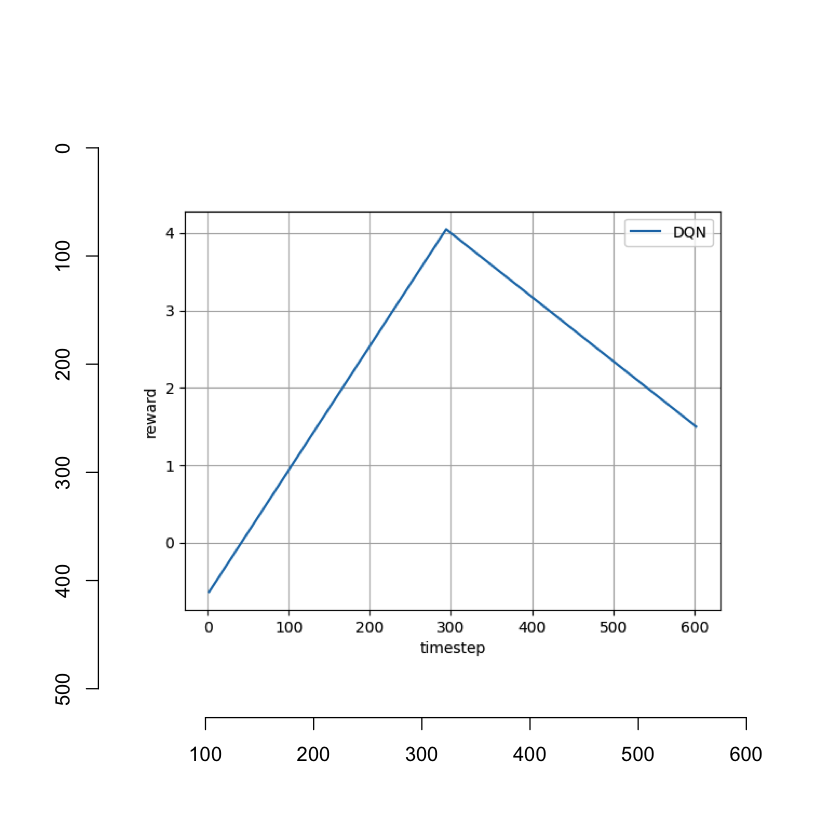

In [20]:
txt <- read.csv(file='./log/performance.csv')
txt
library(imager)
load.image("~/Desktop/log/fig.png") %>% plot

In the end we save model to `models/leduc_holdem_nfsp` .

In [21]:
save_dir = 'models/leduc_holdem_nfsp'
if (!dir.exists(save_dir)){
    os$makedirs(save_dir)}
saver = tf$train$Saver()
saver$save(sess, os$path$join(save_dir, 'model'))

[1] "models/leduc_holdem_nfsp/model"

### Now you have your no-limit Texas Holdem model.
## Good Job!

___